0.03025044729327568


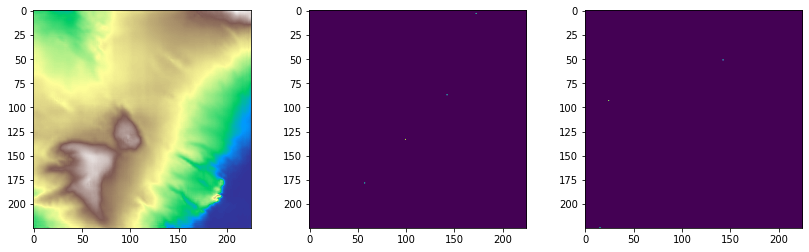

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np

seed = 2333
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed) 

from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
tf.random.set_seed(seed)
with tf.device('/cpu:0'):
    generator = load_model('terrain_generator50000.h5')
    
def proxy(points,show=False):
    if points is None:
        points = []
    source = np.zeros((225,225,2))
    for p in points:
        source[int((p[1]+0.5)*224),int((p[0]+0.5)*224),int(p[2]<0)]=1
    source = source[None]
    w_noise = np.random.normal(0, 1, (1, 14, 14, 1024))
    with tf.device('/cpu:0'):
        predicted = generator.predict([source, w_noise])
    # im = np.uint8(predicted[0, ...] * 127.5 + 127.5) #[-1,1->0,255]
    real_height = predicted[0, ...] 
    real_height = cv2.GaussianBlur(real_height,(5,5),1.0)* 12.5 + 12.5 # -> 0-25cm # smooth
    if show:
        plt.figure(figsize=(14,4))
        plt.subplot(1,3,1)
        plt.imshow(predicted[0],cmap='terrain')
        plt.subplot(1,3,2)
        plt.imshow(source[0,...,0])
        plt.subplot(1,3,3)
        plt.imshow(source[0,...,1])
    elev = real_height[:,:]
    cellsize = 2.5
    px, py = np.gradient(elev, cellsize)
    slope = np.sqrt(px ** 2 + py ** 2)
    slope = np.abs(np.arctan(slope)/np.pi*2)   
    score = 0.3 * np.std(slope) + 0.5 * np.mean(slope)**2 + 0.2 * np.mean(np.abs(elev-np.mean(elev)))/25
    return score

a_dim = 75*75*2+1 # 0:5625, add peak; 5625:11250, add pit; 11250 terminate
def decode_action(i):
    """
    input: int i in range(0,11251)
    return: none for terminate 11250, else normalized 3d vector in [-1, 1]
    """
    if i == 11250:
        return None # terminate
    z = 1 if i < 5625 else -1 # peak or pit
    x = (i%5625)%75
    y = (i%5625)//75
    return [(x-37)/74, (y-37)/74, z]

def encode_state(s):
    """
    input: none for blank, normalized vectors of (n,3) for point lists
    output: a set of used points for action numbers
    """
    if not s:
        return []
    points1 = [int((p[0]*74+37) + (p[1]*74+37)*75) for p in s]
    points2 = [int((p[0]*74+37) + (p[1]*74+37)*75) + 75 * 75 for p in s]
    return points1 + points2

def decode_state(s):
    """
    input: a dict that has keys in range(0,5625) and values in {-1,1}, can be empty
    return: normalized 3-d vectors for each point (element), of shape n*3, can be None for empty dict
    """
    if len(s)==0:
        return None
    keys, values = s.keys(), list(s.values())
    return np.array([[(k%75-37.)/74. for k in keys],[(k//75-37.)/74. for k in keys],values]).T

print(proxy(decode_state({132:1,2222:1,3333:1,4444:1,5555:-1,2333:-1,1322:-1}),show=True))

In [2]:
import torch
import torch.nn as nn
from torch import optim
device = torch.device("cuda:2")
import copy
import random
import time

random.seed(seed) 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) 

In [3]:
class flog(nn.Module):
    def __init__(self,learned_dim=128,device=device,num_head=8):
        super(flog, self).__init__()
        self.learned_dim = learned_dim
        self.device = device
        
        self.learned_start = torch.randn(size=(1,learned_dim), device=self.device, requires_grad=True)
        self.learned_ter = torch.randn(size=(learned_dim,), device=self.device, requires_grad=True) # terminate action
        
        self.s_embedding = nn.Linear(4, learned_dim, device=self.device)
        self.a_embedding = nn.Linear(3, learned_dim, device=self.device)
        
        self.s_q1 = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.s_k1 = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.s_v1 = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.s_enc1 = nn.MultiheadAttention(learned_dim, num_head, batch_first=True, device=self.device)
        
        self.ff1 = nn.Linear(learned_dim, learned_dim, device=self.device)
        
        self.s_q2 = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.s_k2 = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.s_v2 = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.s_enc2 = nn.MultiheadAttention(learned_dim, num_head, batch_first=True, device=self.device)
        
        self.ff2 = nn.Linear(learned_dim, learned_dim, device=self.device)
        
        self.a_q = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.a_sk = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)
        self.a_sv = nn.Linear(learned_dim, learned_dim, device=self.device, bias=False)        
        self.a_dec = nn.MultiheadAttention(learned_dim, num_head, batch_first=True, device=self.device)
        
        self.ffa = nn.Linear(learned_dim, learned_dim, device=self.device)
        
        self.output = nn.Linear(learned_dim, 1, device=self.device)
        
        # should add a length token, as the fourth dim for 3d vector
        
    def embed_s(self,x):
        if not x:
            return self.learned_start
        else:
            # add length token, currently 60 # zcedit
            _ = np.array([[len(x)/30.-1.] for xx in x])
            x = np.concatenate([np.array(x),_],axis=1)
#             print(x.shape)
            return torch.cat([self.learned_start, self.s_embedding(
            torch.Tensor(x).to(self.device))],axis=0)
        
    def forward(self, s, a):
        """
        batched
        s: (B,n*,3), a:(B,3*)
        """
        s = [self.embed_s(x) for x in s] # (B,n*+1,d)
        length = np.array([len(_) for _ in s]) #(B,)
        mask = torch.zeros((len(length),length.max()),device = self.device) # (B, max_len = nmax+1)
        mask[(torch.arange(mask.shape[0]),length-1)] = 1
        mask = (1-mask.flip([-1]).cumsum(-1).flip([-1])).bool()
#         print(mask)
        s = nn.utils.rnn.pad_sequence(s, batch_first=True, padding_value=0.0) #(B,nmax+1,d)
        
        a = [self.a_embedding(torch.Tensor(x).to(self.device)) if x else self.learned_ter for x in a] # (B,[d])
        a = [torch.unsqueeze(torch.unsqueeze(x,0),0) for x in a]  # (B,[1,1,d])
        a = torch.cat(a,0) # (B,1,d)
        
        s1,_ = self.s_enc1(self.s_q1(s), self.s_k1(s), self.s_v1(s), 
                           key_padding_mask = mask, need_weights=True) # self attention
#         print(_)
        s1 = s + s1
        s1 = s1 + nn.functional.gelu(self.ff1(s1))
        
        s2,_ = self.s_enc2(self.s_q2(s1), self.s_k2(s1), self.s_v2(s1),
                           key_padding_mask = mask, need_weights=True) # self attention
        s2 = s1 + s2
        s2 = s2 + nn.functional.gelu(self.ff2(s2))
        
        sa,_ = self.a_dec(self.a_q(a), self.a_sk(s2), self.a_sv(s2),
                          key_padding_mask = mask, need_weights=True) # cross
        sa = a + sa
        sa = sa + nn.functional.gelu(self.ffa(sa))
        
        est_flog = self.output(sa) # (B,1,1)
        
        return est_flog
    

In [ ]:
model = flog()
# model = nn.DataParallel(model)
# model.to(device)

In [ ]:
epsilon = 1e-6
def rew_shape(r,difficulty='hard'):
    if difficulty == 'hard':
        # < 0.03 bad, > 0.06 good
        rew = epsilon + r * (10**(100*r-5))
        return rew

def get_in_flow(s):
    # enumerate s_prev and corresponding a
    # calculate their flows
    # return eps + sum exp flog(s,a)
    assert s is not None
    s_prev = [copy.deepcopy(s) for i in range(len(s))]
    actions = [s[i] for i in range(len(s))]
    _ = [s_prev[i].pop(i) for i in range(len(s))]
    sumflow = torch.sum(torch.exp( torch.clamp(model(s_prev,actions), min=-60, max=60) ))  # clamp
    return epsilon + sumflow

def get_out_flow(s):
    # sample potential a \in A(s)
    # get their flows
    # return actions and flogs with ln(ter), can make decision with softmax
    terminate_r = np.log(rew_shape(proxy(s)))
    used_points = encode_state(s)
    a_feas = [x for x in range(11250) if x not in used_points ] # feasible actions
    if len(a_feas)>0 and len(used_points)<60*2: # zc edit
#         print(len(used_points))
        actions = [decode_action(i) for i in a_feas]
        repeated_states = [s for i in a_feas]
        flogs = torch.clamp(model(repeated_states, actions), min = -60, max = 60)  # clamp
        del actions 
        del repeated_states
        a_feas.append(11250) # add the termination action
        return a_feas, torch.cat([flogs[:,0,0],torch.Tensor([terminate_r]).to(device)])
    else:
        return [11250], torch.Tensor([terminate_r]).to(device)

def decision(a_feas,logs):
    prob = torch.softmax(logs,0).detach().cpu().numpy()
    prob = 0.05 * 1/len(a_feas) + 0.95 * prob
    action = random.choices(a_feas, weights=prob, k=1)[0]
    return decode_action(action)

def trans(s,a):
    if a is None:
        return None
    if s is None:
        return [a]
    snew = copy.deepcopy(s)
    snew.append(a)
    return snew

def sample_traj():
    s0 = None
    s = s0
    action = -1
    while action:
        a, logs = get_out_flow(s)
        action = decision(a,logs)
        del logs
        if action:
            s = trans(s,action)
        else:
            return s

def parse_traj(a):
    # to decompose the list to a sequence of states
    if a:
        return [a[:i] for i in range(1,len(a)+1)]
    else:
        return []
        

def no_explore_decision(a_feas,logs):
    prob = torch.softmax(logs,0).detach().cpu().numpy()
#     prob = 0.05 * 1/len(a_feas) + 0.95 * prob
    action = random.choices(a_feas, weights=prob, k=1)[0]
    return decode_action(action)

def no_explore_sample_traj():
    s0 = None
    s = s0
    action = -1
    while action:
        a, logs = get_out_flow(s)
        action = no_explore_decision(a,logs)
        del logs
        if action:
            s = trans(s,action)
        else:
            return s

def sampled_sum_get_out_flow(s):
    terminate_r = np.log(rew_shape(proxy(s)))
    used_points = encode_state(s)
    a_feas = [x for x in range(11250) if x not in used_points ] # feasible actions
    add_on_num = len(a_feas)  # terminate not included
    if len(a_feas)>0 and len(used_points)<60*2: # zc edit
        sampled_a = random.sample(a_feas, k=1000) # zc edit
        actions = [decode_action(i) for i in sampled_a]
        repeated_states = [s for i in sampled_a]
        flogs = torch.clamp(model(repeated_states, actions), min = -60, max = 60)  # clamp
        del actions 
        del repeated_states
        return epsilon + np.exp(terminate_r) + torch.sum(torch.exp(flogs)) * add_on_num/len(sampled_a)
    else:
        return torch.sum(torch.Tensor([epsilon + np.exp(terminate_r)]).to(device))

def full_explore_sample_traj(length=60):
    s0 = None
    s = s0
    action = -1
    while action:
        used_points = encode_state(s)
        a_feas = [x for x in range(11250) if x not in used_points]
        if len(a_feas)>0 and len(used_points)< length * 2:  # zc edit
            a_feas.append(11250) # add the termination action
        else:
            a_feas = [11250]
        
        action = random.choices(a_feas, k=1)[0]
        action = decode_action(action)
        if action:
            s = trans(s,action)
        else:
            return s

In [ ]:
memory = []
sampled_terrains = []
crit = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3)
def get_lr(x):
    return 0.2 # 2e-4
#     if x < 60.5:
#         return x/60
#     else:
#         return max(0.1,1-(x-60)/120)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch:get_lr(epoch))
batch_traj = 4 # zcedit

high_quality_cnt = 0
high_quality_terrain = []

pre_sample = 60
for i in range(pre_sample):
    print('pre sampling')
    traj = full_explore_sample_traj(i+1)
    memory.append(traj)
    score = proxy(traj)
    if traj:
        print('sampled a traj of len',len(traj),', score', score,
              'reshaped score log',np.log(rew_shape(score)), '# traj',len(memory))
    else:
        print('get none traj, score', score, '# traj', len(memory))
    sampled_terrains.append((traj,score))
    if score > 0.06:
        high_quality_cnt += 1
        high_quality_terrain.append(traj)
        print('hit high quality! # high quality terrains:',high_quality_cnt)

In [ ]:
tic = time.time()
while len(memory)<361:
        
    print('walltime: [%.1f s] | sampling...'%(time.time()-tic))
    traj = sample_traj()
    memory.append(traj)
    score = proxy(traj)
    if traj:
        print('sampled a traj of len',len(traj),', score', score,
              'reshaped score log',np.log(rew_shape(score)), '# traj',len(memory))
    else:
        print('get none traj, score', score, '# traj', len(memory))
    sampled_terrains.append((traj,score))
    if score > 0.06:
        high_quality_cnt += 1
        high_quality_terrain.append(traj) # dont use this
        print('hit high quality! # high quality terrains:',high_quality_cnt)

    if len(memory)>=batch_traj:
        print('walltime: [%.1f s] | optimizing...'%(time.time()-tic))
        for _opt_step in range(2):
            aaa = random.sample(memory, k=batch_traj)
            cum_loss = 0
            for x in aaa:
                s_series = parse_traj(x)
                for s in s_series:
                    inward = torch.log(get_in_flow(s))
    #                 outward = torch.log(torch.sum(torch.exp(get_out_flow(s)[1]))+epsilon)
                    outward = torch.log(sampled_sum_get_out_flow(s))
                    loss = crit(inward, outward)/batch_traj
                    cum_loss += loss.item() # *batch_traj  # get average
                    loss.backward()
            print('cumulative loss',cum_loss)
            nn.utils.clip_grad_norm_(model.parameters(), 20, norm_type=2)
            optimizer.step()
            optimizer.zero_grad()
        print('lr',scheduler.get_last_lr())
        scheduler.step()
        
    if len(memory) % 60 == 0:
        print('saving model')
        torch.save(model, "model_iter"+str(len(memory))+".pth")

In [ ]:
model = torch.load('model_iter360.pth')
optimizer.zero_grad()
outputs = []
outputs_len = []
for i in range(100):
    _ = no_explore_sample_traj()
    score_ = proxy(_)
    outputs.append(score_)
    outputs_len.append(len(_))
    print(i+1,len(_),score_)

In [ ]:
plt.scatter(outputs_len,outputs)

In [ ]:
plt.plot([x[-1] for x in sampled_terrains[:360]])